In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# some vectorizers
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import json
import torch
import torch.nn as nn

%matplotlib inline

In [2]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

In [3]:
df.head()

,text,confirmed,suggested,labels
0,Slut på medicin.,"[89, 651]",[348],"[Känd astma, Känd lungsjukdom]"
1,Ångest,[],[118],[]
2,"Tänkte bara höra med Er, när jag har möjlighet...",[],"[89, 913]",[]
3,Behöver att prata med psykolog angående använd...,"[116, 215]","[215, 348, 446]","[Nedstämdhet, Trötthet]"
4,Har fått besvärlig eksem på händerna,"[2, 141]",[141],"[Hudbesvär, Synliga hudbesvär]"


In [4]:
# functions for preprocessing
def clean_text(text):
    # turn text to lowercase
    text = text.lower()
    
    # remove all characters that are not letters or whitespace
    text = re.sub(r'[^\p{L} ]', '', text)
    
    return text

In [5]:
# create X matrix
texts = df['text'].tolist()

for i in range(len(texts)):
    texts[i] = clean_text(texts[i])
    
if False:
    # create list of dicts for DictVectorizer
    dicts = []

    for i in range(len(texts)):
        temp_dict = {}
        text_list = texts[i].split()

        for w in text_list:
            if w in temp_dict:
                temp_dict[w] += 1
            else:
                temp_dict[w] = 1

        dicts.append(temp_dict)

v = TfidfVectorizer(max_features=5000)
X = v.fit_transform(texts).todense()

In [6]:
# create y matrix (labels)
labels = df['labels'].tolist()

multilab_bin = MultiLabelBinarizer()
y = multilab_bin.fit_transform(labels)

In [7]:
# turn X and y into tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

In [8]:
# define the NN
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, H1)
        self.fc2 = nn.Linear(H1,D_out)
        #self.fc3 = nn.Linear(H2,D_out)
        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)#self.relu(self.fc2(x))
        #x = self.relu(self.fc3(x))
        x = self.sigm(x)
        return x

In [9]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1


In [10]:
# prepare the data for the training and test
batch_size = 64

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True)

train_set = torch.utils.data.TensorDataset(X_train, y_train)
test_set = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size,
                                          shuffle=True
                                          )
# might be unnecessary to use a loader for the test set right now
test_loader = torch.utils.data.DataLoader(dataset=train_set,
                                         batch_size=batch_size,
                                         shuffle=True)

In [11]:
# define the model
D_in, H1, D_out = X.shape[1], 200, y.shape[1]

model = Net(D_in, H1, D_out)
model = model.to(device)


# training loop
learning_rate = 0.004

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []

num_epochs = 10
for epoch in range(num_epochs):
    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # save the loss
        losses.append(loss)

0.6042718446601941


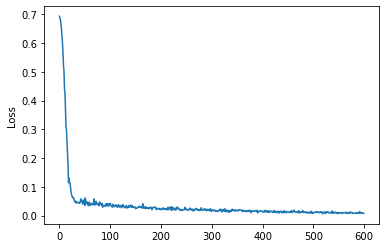

In [12]:
y_pred = model(X_test.to(device))
y_pred = y_pred.cpu().detach().numpy()

# set all values above threshold to 1, else 0
th = 0.3
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

print(f1_score(y_test, y_pred, average='micro'))

plt.plot(losses)
plt.ylabel('Loss')
plt.show()